In [1]:
# numerics
import numpy as np
import itertools

# images
from scipy.misc import *
#imresize, imread, imshow
import matplotlib.pylab as plt

# dealing with tar files
import tarfile, gzip

# extracting data about faces/people
import csv

# nice stuff
import os, re
from pprint import pprint

#progressbar
import time
import progressbar

import imageio

In [2]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from scipy.misc import imresize 
from keras.layers import *

Using TensorFlow backend.


In [25]:
def load_image_base(basename, number):
    filename = "images/{0}/{1}".format(basename, number)
    #print(filename)
    return imageio.imread(filename)

In [28]:
characters = os.listdir("images")
characters

['UN',
 'DIM2',
 'GA',
 'DI',
 'SAL',
 'NU',
 'DU',
 'NI',
 'MA',
 'GI',
 'DA',
 'KUR',
 'MU',
 'DIB',
 'NA',
 'AB',
 'LUGAL',
 'TUR',
 'IN',
 'LAL',
 'RU',
 'RI',
 'A',
 'RA',
 'ZI',
 'UD',
 'KID-E2',
 'ZU',
 'IGI',
 'ZA',
 'GAL',
 'SI',
 'AN',
 'ME',
 'BA',
 'KI',
 'NE',
 'BI',
 'TUG2',
 'KA',
 'KU3',
 'IM',
 'LU',
 'NAM',
 'EN',
 'IB',
 'LA',
 'TA',
 'E',
 'LU2']

In [16]:
load_image_base(characters[0], 1).shape

(64, 64, 3)

In [17]:
def extract_features(z):
    features = np.array([z[:,:,0],z[:,:,1],z[:,:,2]])
    return features

In [46]:
def loaddata(characters):
    trainX = []
    trainY = []
    for i in progressbar.progressbar(range(len(characters))):
        imagesC = os.listdir("images/"+characters[i])
        for j in imagesC:
            trainX.append(extract_features(load_image_base(characters[i], j)))
            trainY.append(i)
    return np.asarray(trainX).astype('float64'), np.asarray(trainY).astype('float64')

In [47]:
trainX, trainY = loaddata(characters)

100% (50 of 50) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


In [48]:
trainX.shape

(4416, 3, 64, 64)

In [49]:
trainY.shape

(4416,)

In [50]:
trainX[0]

array([[[255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.],
        ...,
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.]],

       [[255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.],
        ...,
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.]],

       [[255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.],
        ...,
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.]]])

In [56]:
def crop_and_downsample(originalX, downsample_size=32):
    """
    Starts with a 250 x 250 image.
    Crops to 128 x 128 around the center.
    Downsamples the image to (downsample_size) x (downsample_size).
    Returns an image with dimensions (channel, width, height).
    """
    current_dim = 64
    target_dim = 64
    margin = int((current_dim - target_dim)/2)
    left_margin = margin
    right_margin = current_dim - margin

    # newim is shape (3, 64, 64)
    newim = originalX[:, left_margin:right_margin, left_margin:right_margin]

    # resized are shape (feature_width, feature_height, 3)
    feature_width = feature_height = downsample_size
    resized1 = imresize(newim[0:3,:,:], (feature_width, feature_height), interp="bicubic", mode="RGB")
    #resized2 = imresize(newim[3:6,:,:], (feature_width, feature_height), interp="bicubic", mode="RGB")

    # re-packge into a new X entry
    #newX = np.concatenate([resized1,resized2], axis=2)
    newX = resized1
    
    # the next line is EXTREMELY important.
    # if you don't normalize your data, all predictions will be 0 forever.
    newX = newX/255.0
    
    return newX

In [71]:
ds = 32
Xtrain = np.asarray([crop_and_downsample(x, downsample_size=ds) for x in trainX])

/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [72]:
print(Xtrain.shape)

(4416, 32, 32, 3)


In [73]:
im = Xtrain[1]
np.shape(im)

(32, 32, 3)

In [74]:
im

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

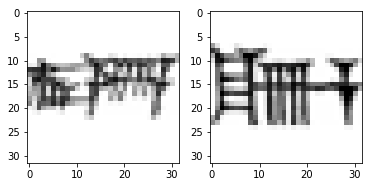

In [75]:
fig = plt.figure()
ax1, ax2 = [fig.add_subplot(1,2,i+1) for i in range(2)]
ax1.imshow(Xtrain[5,:,:,0:3])
ax2.imshow(Xtrain[6,:,:,0:3])
plt.show()

In [76]:
nb_classes = len(characters)
# convert class vectors to binary class matrices
Ytrain = np_utils.to_categorical(trainY, nb_classes)

In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(Xtrain, Ytrain, test_size=0.02, random_state=42)

In [90]:
np.shape(Y_train), np.shape(Y_test)

((4327, 50), (89, 50))

In [91]:
# input image dimensions
img_count , img_rows, img_cols, img_channels = np.shape(X_train)

In [92]:
img_count , img_rows, img_cols, img_channels

(4327, 32, 32, 3)

In [93]:
# A common Conv2D model
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same',
                        input_shape=(img_rows, img_cols, img_channels)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))


print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
activation_14 (Activation)   (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 32)          0         
__________

In [94]:
batch_size=256
epochs=50

In [95]:
# initiate RMSprop optimizer
opt = keras.optimizers.Adam(lr=3e-4)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [96]:
history = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=epochs, verbose=1, validation_data=(X_test, Y_test))

/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 4327 samples, validate on 89 samples
Epoch 1/50
4327/4327 [==============================] - 5s 1ms/step - loss: 3.8634 - acc: 0.0361 - val_loss: 3.8531 - val_acc: 0.0225
Epoch 2/50
4327/4327 [==============================] - 4s 962us/step - loss: 3.7804 - acc: 0.0446 - val_loss: 3.8479 - val_acc: 0.0225
Epoch 3/50
4327/4327 [==============================] - 4s 960us/step - loss: 3.7667 - acc: 0.0462 - val_loss: 3.8396 - val_acc: 0.0449
Epoch 4/50
4327/4327 [==============================] - 4s 950us/step - loss: 3.7475 - acc: 0.0557 - val_loss: 3.8293 - val_acc: 0.0449
Epoch 5/50
4327/4327 [==============================] - 5s 1ms/step - loss: 3.7118 - acc: 0.0712 - val_loss: 3.7904 - val_acc: 0.0899
Epoch 6/50
4327/4327 [==============================] - 5s 1ms/step - loss: 3.6337 - acc: 0.1033 - val_loss: 3.6894 - val_acc: 0.1461
Epoch 7/50
4327/4327 [==============================] - 5s 1ms/step - loss: 3.3753 - acc: 0.1609 - val_loss: 3.3552 - val_acc: 0.1798
Epoch 8/50

In [97]:
res1 = model.predict(X_train)
res2 = model.predict(X_test)

In [101]:
characters[np.argmax(res2[0])]

'LAL'

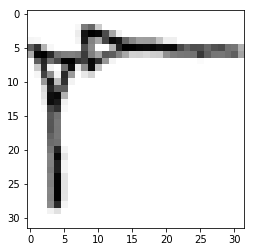

In [105]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.imshow(X_test[0,:,:,0:3])
plt.show()